# viz

> Fill in a module description here

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp viz

In [ ]:
#| export
from fastdot import *
from IPython.display import SVG, display
from neev.engine import *

Install `fastdot` using `mamba install -c fastai fastdot`

In [ ]:
#| hide
!pwd

/Users/kaushik.sinha/ws_p/neev/nbs


In [ ]:
#| export
def trace(root:Value):# root node of the computation graph
    '''builds a set of all nodes and edges in a graph'''
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

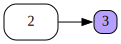

In [ ]:
#|hide
g = Dot(rankdir='LR',directed=True)

n1 = Node('2', name='blah', fillcolor=None)
n2 = Node('3', name='foo', height=0.25, width=0.25)
g.add_items(n1, n2, n1.connect(n2))
# g.add_item()
g

In [ ]:
#|hide
g = Dot(rankdir='LR',directed=True)

n1 = g.add_item('2', name='blah',height=0.25, width=0.25)
n2 = g.add_item('3', name='*foo',height=0.25, width=0.25)
n3 = g.add_item('4', name='b1ar',height=0.25, width=0.25)
n4 = g.add_item('5', name='b+ar',height=0.25, width=0.25)
n5 = g.add_item('5', name='0_ar',height=0.25, width=0.25)
n6 = g.add_item('6', name='_ar',height=0.25, width=0.25)
n7 = g.add_item('7', name='**-1',height=0.25, width=0.25)
n8 = g.add_item('8', name='POWM1',height=0.25, width=0.25)
n9 = g.add_item('9', name='POW-1',height=0.25, width=0.25)
n10 = g.add_item('10', name='POW1',height=0.25, width=0.25)
n11 = g.add_item('11', name='POW.5',height=0.25, width=0.25)
g.add_items(n1.connect(n2), n2.connect(n3),n3.connect(n4),
            n4.connect(n5),n5.connect(n6),n6.connect(n7),
            n7.connect(n8), n8.connect(n9), n9.connect(n10), 
            n10.connect(n11)
           )
g

In [ ]:
#|hide
# Note the following results in an empty list :(
# i.e., we are not able to retrieve the node even though
# it exists.
assert g.get_node('*foo') == []
assert g.get_node('b+ar') == []
assert g.get_node('0_ar') == []
assert g.get_node('**-1') == []
assert g.get_node('POWM1') != []
assert g.get_node('POW-1') == []
assert g.get_node('POW1') != []
assert g.get_node('POW.5') == []

In [ ]:
#|hide
# We can only get a node whose name starts with letters
g.get_node('blah')

[<pydot.Node>]

In [ ]:
#|hide
g.get_node('b1ar'), g.get_node('_ar')

([<pydot.Node>], [<pydot.Node>])

In [ ]:
#|hide
g.get_node_list()

[<pydot.Node>,
 <pydot.Node>,
 <pydot.Node>,
 <pydot.Node>,
 <pydot.Node>,
 <pydot.Node>,
 <pydot.Node>,
 <pydot.Node>,
 <pydot.Node>,
 <pydot.Node>,
 <pydot.Node>]

In [ ]:
#|hide
for node in g.get_node_list():
    print(node.get_name())

blah
"*foo"
b1ar
"b+ar"
"0_ar"
_ar
"**-1"
POWM1
"POW-1"
POW1
"POW.5"


In [ ]:
#|hide
"**-1".replace('**-','POWM')

'POWM1'

In [ ]:
#|hide
"**1".replace('**-','POWM').replace('**','POW')

'POW1'

In [ ]:
#|hide
"**-.5".replace('.','DOT').replace('**-','POWM').replace('**','POW')

'POWMDOT5'

In [ ]:
#|hide
"**-1.5".replace('.','DOT').replace('**-','POWM').replace('**','POW')

'POWM1DOT5'

In [ ]:
#|export
def get_dot(root:Value,# root node of the computation graph
            rankdir='LR'):# TB (top to bottom graph) | LR (left to right)
    """
    get a pydot graph corresponding to this computation graph
    """
    assert rankdir in ['LR', 'TB']
    
    def get_op_name(op):
        op_dict = {'+' : 'PL', '-': 'MN', 
                   '*' : 'MU', '/': 'DI', 
                   'tanh':'tanh','exp':'exp',
                   'relu':'relu'
                  }
        if op.startswith('**'):
            return (op
                    .replace('.','DOT')
                    .replace('**-','POWM')
                    .replace('**','POW')
                   )
        return op_dict[op]
    
    nodes, edges = trace(root)
    dot = Dot(rankdir=rankdir,directed=True)
    
    for n in nodes:
        # for any value in the graph, create a rectangular (`record`) node for it
        nd_label = f'{n.label} \n data {n.data:.4f} \n grad {n.grad:.4f}'
        nd_name = str(id(n))
        nd = dot.add_item(nd_label, name=nd_name, fillcolor=None)
#         print(f'node:{nd_label};name:{nd_name}')
        if n._op:
            # if this value is the result of some operation create an op node for it
            nd_op_name = get_op_name(n._op) + str(id(n))  
            nd_op = dot.add_item(n._op, 
                                 name=nd_op_name, fillcolor=None, 
                                 height=0.25, width=0.25)
#             print(f'node:{n._op};name:{nd_op_name}')
            # and connect this node to it
            dot.add_item(nd_op.connect(nd))
            
    for n1, n2 in edges:
        n1_nd_name = str(id(n1))
        n1_nd = dot.get_node(n1_nd_name)[0]
        n2_op_nd_name = get_op_name(n2._op) + str(id(n2))
        n2_op_nd = dot.get_node(n2_op_nd_name)[0]
#         print(f'Fetch: {n2_op_nd_name} is {n2_op_nd}')
        # connect n1 to the op node of n2
        dot.add_item(n1_nd.connect(n2_op_nd))
    
    return dot

In [ ]:
#|export
# https://stackoverflow.com/questions/4596962/display-graph-without-saving-using-pydot
# https://stackoverflow.com/questions/30334385/display-svg-in-ipython-notebook-from-a-function
def view_dot(root:Value):# root node of the computation graphg:pydot.Dot
    '''view the computation graph as a svg'''
    g = get_dot(root)
    svg = SVG(g.create_svg())
    display(svg)

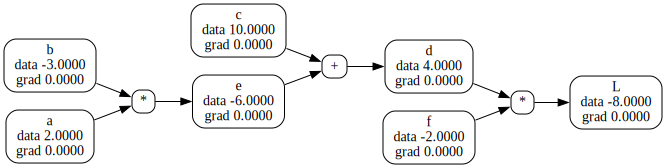

In [ ]:
#|hide
a,b,c = Value(2.,label='a'),Value(-3.,label='b'),Value(10.,label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.); f.label='f'
L = d*f; L.label = 'L'
L

view_dot(L)

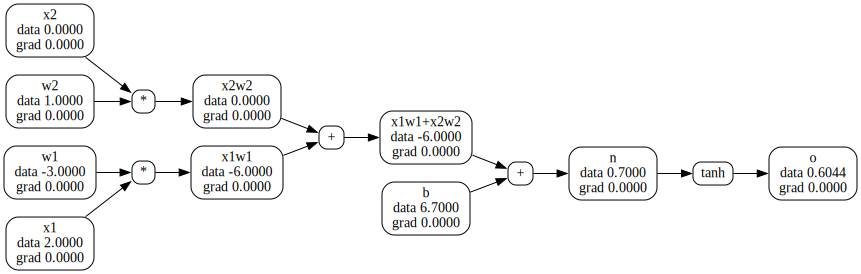

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights of the neuron
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.7, label='b')

x1w1 = x1*w1; x1w1.label='x1w1'
x2w2 = x2*w2; x2w2.label='x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1+x2w2'
n = x1w1x2w2 + b; n.label='n'

o= n.tanh(); o.label='o'
view_dot(o)

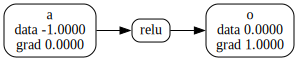

In [ ]:
#|hide
a = Value(-1.,label='a')
o = a.relu(); o.label='o'
o.backward()
view_dot(o)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()